# Machine Learning in Chess to Study Patterns in Chess Games


## Import Libraries


In [133]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, silhouette_score
from warnings import filterwarnings

# Avoid showing warnings to keep the notebook outputs clean.
filterwarnings("ignore")


## Set Up Seaborn Plots


In [2]:
sns.set_theme(context="talk", style="darkgrid")


## Load the Data


In [3]:
DATA_PATH = "../resources/lichess_db_standard_rated_2022/"
# Check whether the DataFrame has been loaded correctly.
df = dd.read_parquet(DATA_PATH, engine="pyarrow")
print(f"Loaded {len(df)} Rated Blitz and Rated Rapid games from 2022.\n")


Loaded 40121728 Rated Blitz and Rated Rapid games from 2022.



## Structure of the Data


In [5]:
print(f"Number of Games: {len(df)}")
print(
    "Number of Unique Players: "
    f"{dd.concat([df['White'], df['Black']]).nunique().compute()}"
)
display(df.head())


Number of Games: 40121728
Number of Unique Players: 2081342


,UTCDateTime,Event,TimeControl,Result,Termination,ECO,Opening,White,Black,WhiteElo,BlackElo,Site
0,2022-01-01 00:00:11,Rated Rapid game,600+0,1-0,Normal,B00,"Nimzowitsch Defense: Scandinavian Variation, A...",shahzad97,mpasha98,1500,1205,https://lichess.org/UMMGcaGz
1,2022-01-01 00:00:11,Rated Blitz game,300+3,0-1,Normal,D00,Queen's Pawn Game: Mason Variation,nicolas_clos,pangma,1430,1412,https://lichess.org/yJI78ET0
2,2022-01-01 00:00:12,Rated Blitz game,300+0,1-0,Normal,E97,"King's Indian Defense: Orthodox Variation, Aro...",oyuka79,JUAN121,2422,2292,https://lichess.org/mrPOJU0W
3,2022-01-01 00:00:12,Rated Blitz game,300+0,1-0,Normal,C22,Center Game: Berger Variation,manoharkatwa,RigoBam,1241,1221,https://lichess.org/YJ1AIn03
4,2022-01-01 00:00:12,Rated Blitz game,300+0,0-1,Time forfeit,A40,Modern Defense,raffrantic1,Carly001,1044,1091,https://lichess.org/RATgKCCm


## Distribution of Player Ratings


In [6]:
# Merge the counts into one, as the player's side isn't important.
white_rating_count = df["WhiteElo"].value_counts().compute()
black_rating_count = df["BlackElo"].value_counts().compute()
rating_counts = (
    pd.concat([white_rating_count, black_rating_count], axis=1).fillna(0).astype(int)
)
rating_counts = rating_counts.sum(axis=1)
# Find the minimum and maximum player rating.
max_rating = rating_counts.index.max()
min_rating = rating_counts.index.min()
print(f"Maximum Player Rating: {max_rating}")
print(f"Minimum Player Rating: {min_rating}")

# Define the bin edges for player ratings from 600 (minimum in Lichess) to
# 3600 in intervals of 200.
rating_bins = np.arange(600, 3601, 200)
rating_counts.index = pd.cut(rating_counts.index, bins=rating_bins)
merged_rating_counts = rating_counts.groupby(level=0).sum()
display(merged_rating_counts)


Maximum Player Rating: 3485
Minimum Player Rating: 600


(600, 800]        687535
(800, 1000]      3156347
(1000, 1200]     7207254
(1200, 1400]    11272801
(1400, 1600]    14835190
(1600, 1800]    16155957
(1800, 2000]    14200749
(2000, 2200]     8550908
(2200, 2400]     3183947
(2400, 2600]      817814
(2600, 2800]      142142
(2800, 3000]       11622
(3000, 3200]         382
(3200, 3400]          42
(3400, 3600]           1
dtype: int64

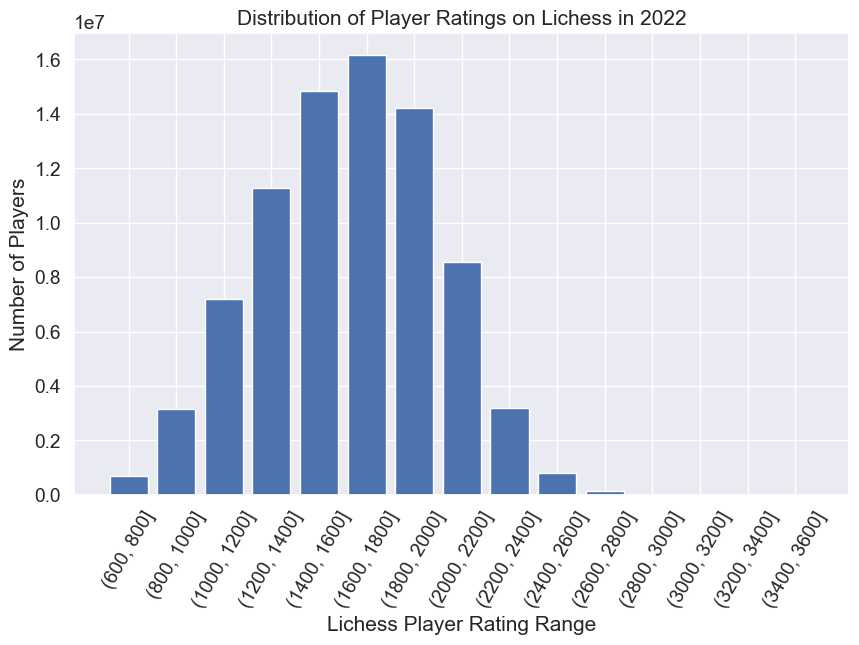

In [7]:
# Plot a graph to show the distribution of player ratings.
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(10, 6))
indexes = merged_rating_counts.index.astype(str)
values = merged_rating_counts.values
ax.bar(indexes, values)
ax.set_title("Distribution of Player Ratings on Lichess in 2022")
ax.set_xlabel("Lichess Player Rating Range")
ax.set_ylabel("Number of Players")
ax.set_xticklabels(indexes, rotation=60)
plt.show()


## Most Popular Openings by Category


### All Rated Players


In [8]:
# Find the most common ECO categories.
eco_categories = df["ECO"].str[0].value_counts().compute()
print("All Players:")
display(eco_categories)


All Players:


C    14070192
B    11256591
A     8653831
D     5478963
E      629352
?       32799
Name: ECO, dtype: Int64

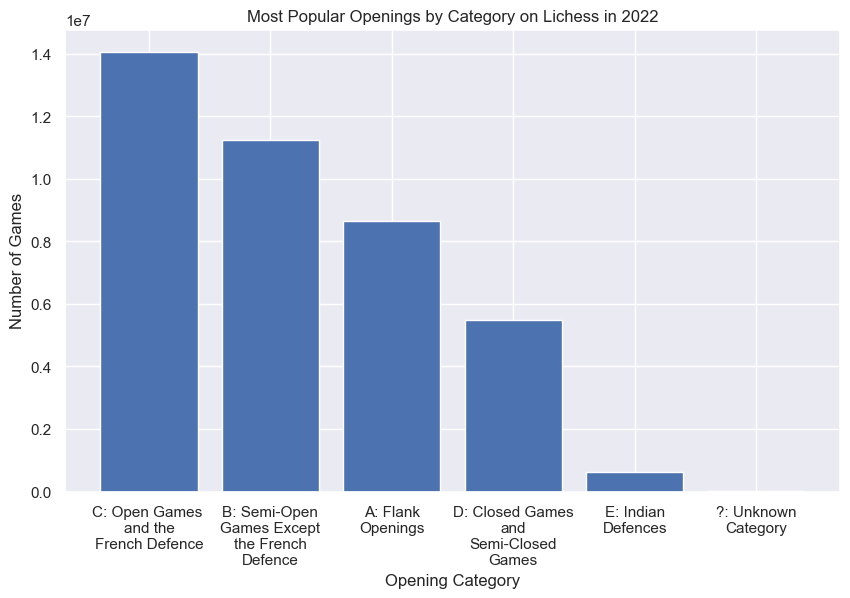

In [9]:
# Map each opening category to its type.
opening_category_map = {
    "A": "Flank\nOpenings",
    "B": "Semi-Open\nGames Except\nthe French\nDefence",
    "C": "Open Games \nand the\nFrench Defence",
    "D": "Closed Games\nand\nSemi-Closed\nGames",
    "E": "Indian\nDefences",
    "?": "Unknown\nCategory",
}

# Plot the number of games in each opening category.
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(10, 6))
indexes = eco_categories.index
values = eco_categories.values
ax.bar(indexes, values)
ax.set_title("Most Popular Openings by Category on Lichess in 2022")
ax.set_xlabel("Opening Category")
ax.set_ylabel("Number of Games")
ax.set_xticklabels(
    [str(f"{index}: {opening_category_map[index]}") for index in indexes]
)
plt.show()


### High Rated Players (Rating 2000+)


Players with Rating 2000 and Above:


B    2176694
A    1675378
C    1352678
D     902553
E     269989
?       5467
Name: ECO, dtype: Int64

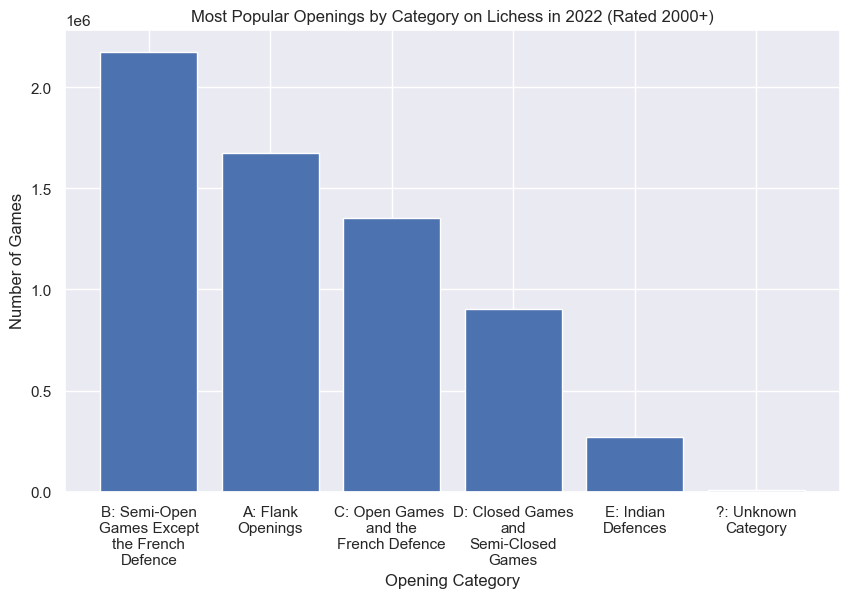

In [10]:
# Find the most common ECO categories for players rated 2000 and above.
high_rated_eco_categories = (
    df[df["WhiteElo"] >= 2000]["ECO"].str[0].value_counts().compute()
)
print("Players with Rating 2000 and Above:")
display(high_rated_eco_categories)

# Plot the number of games in each opening category.
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(10, 6))
indexes = high_rated_eco_categories.index
values = high_rated_eco_categories.values
ax.bar(indexes, values)
ax.set_title("Most Popular Openings by Category on Lichess in 2022 (Rated 2000+)")
ax.set_xlabel("Opening Category")
ax.set_ylabel("Number of Games")
ax.set_xticklabels(
    [str(f"{index}: {opening_category_map[index]}") for index in indexes]
)
plt.show()


### Mid Rated Players (Rating 1201-1999)


Players with Rating 1201-1999:


C    10228118
B     7905666
A     5844439
D     3859371
E      346316
?       19882
Name: ECO, dtype: Int64

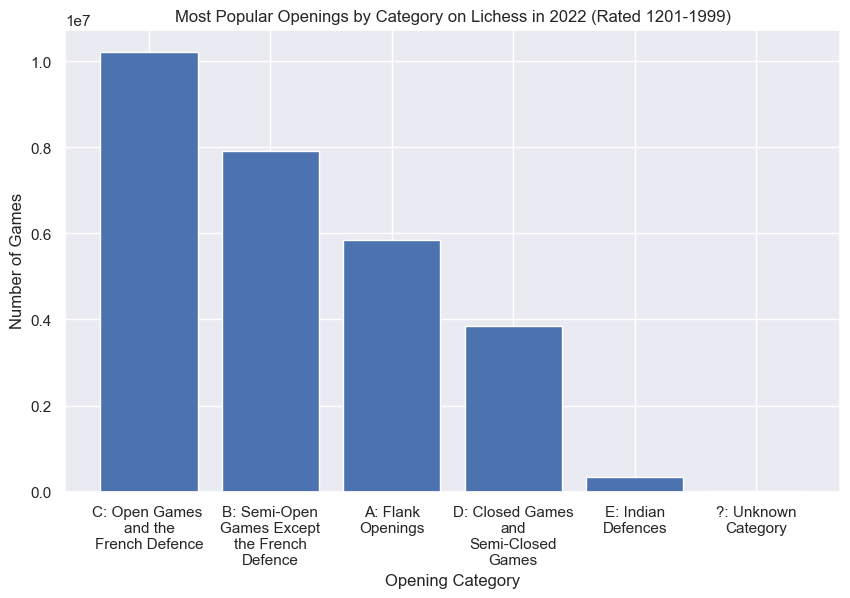

In [11]:
# Find the most common ECO categories for players rated 1401-1999.
mid_rated_eco_categories = (
    df[(df["WhiteElo"] >= 1201) & (df["WhiteElo"] <= 1999)]["ECO"]
    .str[0]
    .value_counts()
    .compute()
)
print("Players with Rating 1201-1999:")
display(mid_rated_eco_categories)

# Plot the number of games in each opening category.
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(10, 6))
indexes = mid_rated_eco_categories.index
values = mid_rated_eco_categories.values
ax.bar(indexes, values)
ax.set_title("Most Popular Openings by Category on Lichess in 2022 (Rated 1201-1999)")
ax.set_xlabel("Opening Category")
ax.set_ylabel("Number of Games")
ax.set_xticklabels(
    [str(f"{index}: {opening_category_map[index]}") for index in indexes]
)
plt.show()


### Low Rated Players (Rating 1200 and Below)


Players with Rating 1200 and Below:


C    2489396
B    1174231
A    1134014
D     717039
E      13047
?       7450
Name: ECO, dtype: Int64

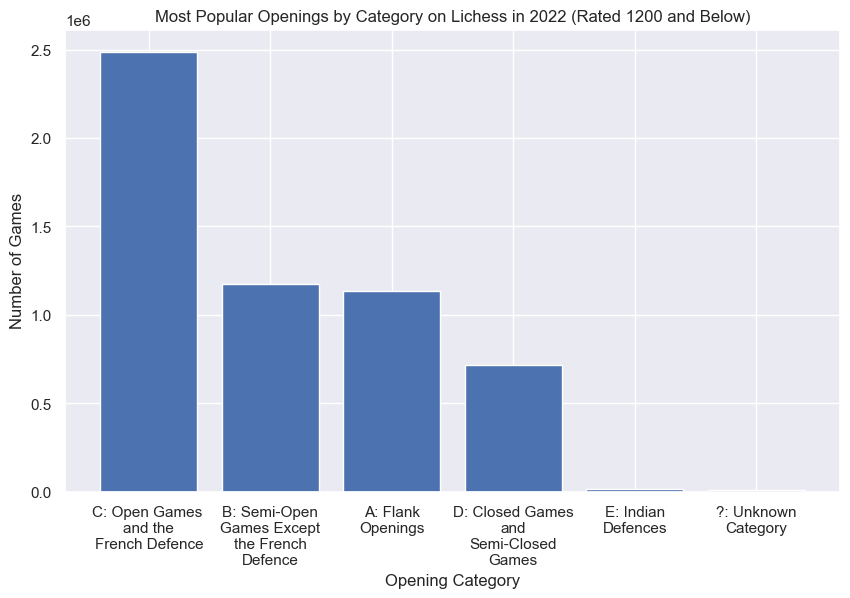

In [12]:
# Find the most common ECO categories for players rated 1400 and below.
low_rated_eco_categories = (
    df[df["WhiteElo"] <= 1200]["ECO"].str[0].value_counts().compute()
)
print("Players with Rating 1200 and Below:")
display(low_rated_eco_categories)

# Plot the number of games in each opening category.
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(10, 6))
indexes = low_rated_eco_categories.index
values = low_rated_eco_categories.values
ax.bar(indexes, values)
ax.set_title(
    "Most Popular Openings by Category on Lichess in 2022 (Rated 1200 and Below)"
)
ax.set_xlabel("Opening Category")
ax.set_ylabel("Number of Games")
ax.set_xticklabels(
    [str(f"{index}: {opening_category_map[index]}") for index in indexes]
)
plt.show()


## Most Popular Base Openings


### Create BaseOpening Column


In [5]:
# Group variations of the same opening together by splitting on the colon.
df["BaseOpening"] = df["Opening"].str.split(":").str[0]
display(df.head())


,UTCDateTime,Event,TimeControl,Result,Termination,ECO,Opening,White,Black,WhiteElo,BlackElo,Site,BaseOpening
0,2022-01-01 00:00:11,Rated Rapid game,600+0,1-0,Normal,B00,"Nimzowitsch Defense: Scandinavian Variation, A...",shahzad97,mpasha98,1500,1205,https://lichess.org/UMMGcaGz,Nimzowitsch Defense
1,2022-01-01 00:00:11,Rated Blitz game,300+3,0-1,Normal,D00,Queen's Pawn Game: Mason Variation,nicolas_clos,pangma,1430,1412,https://lichess.org/yJI78ET0,Queen's Pawn Game
2,2022-01-01 00:00:12,Rated Blitz game,300+0,1-0,Normal,E97,"King's Indian Defense: Orthodox Variation, Aro...",oyuka79,JUAN121,2422,2292,https://lichess.org/mrPOJU0W,King's Indian Defense
3,2022-01-01 00:00:12,Rated Blitz game,300+0,1-0,Normal,C22,Center Game: Berger Variation,manoharkatwa,RigoBam,1241,1221,https://lichess.org/YJ1AIn03,Center Game
4,2022-01-01 00:00:12,Rated Blitz game,300+0,0-1,Time forfeit,A40,Modern Defense,raffrantic1,Carly001,1044,1091,https://lichess.org/RATgKCCm,Modern Defense


### All Rated Players


In [6]:
# Count the number of games played in each opening with variations grouped
# together.
base_opening_counts = df["BaseOpening"].value_counts().compute()
display(base_opening_counts)

# Calculate what proportion of all games the top 15 openings account for.
top_15_openings = base_opening_counts[:15]
top_15_openings_proportion = top_15_openings.sum() / base_opening_counts.sum()
print(
    f"The top 15 openings account for {top_15_openings_proportion:.2%} of all "
    "games on Lichess in 2022."
)


Sicilian Defense        4492781
Queen's Pawn Game       3403077
French Defense          2266247
Scandinavian Defense    1979982
Italian Game            1868665
                         ...   
Venezolana Opening           29
Formation                    24
Dresden Opening              16
Amar Gambit                  15
Veresov Opening               9
Name: BaseOpening, Length: 162, dtype: int64

The top 15 openings account for 63.68% of all games on Lichess in 2022.


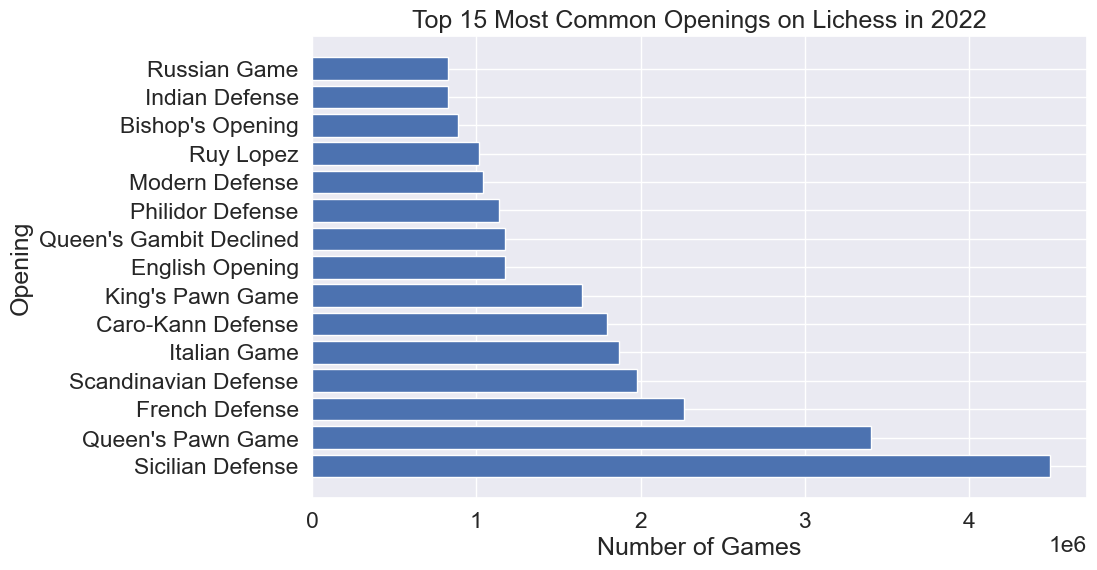

In [14]:
# Plot the top 15 most common openings.
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10, 6))
indexes = base_opening_counts.index[:15]
values = base_opening_counts.values[:15]
ax.barh(indexes, values)
ax.set_title("Top 15 Most Common Openings on Lichess in 2022")
ax.set_xlabel("Number of Games")
ax.set_ylabel("Opening")
plt.show()


### High Rated Players (Rating 2000+)


Sicilian Defense      1080298
French Defense         429823
Queen's Pawn Game      409113
Caro-Kann Defense      376911
English Opening        311541
                       ...   
English Rat                 6
Amsterdam Attack            3
Venezolana Opening          2
Veresov Opening             2
Tayler Opening              1
Name: BaseOpening, Length: 161, dtype: int64

The top 15 openings for players rated 2000+ account for 10.80% of all games on Lichess in 2022.


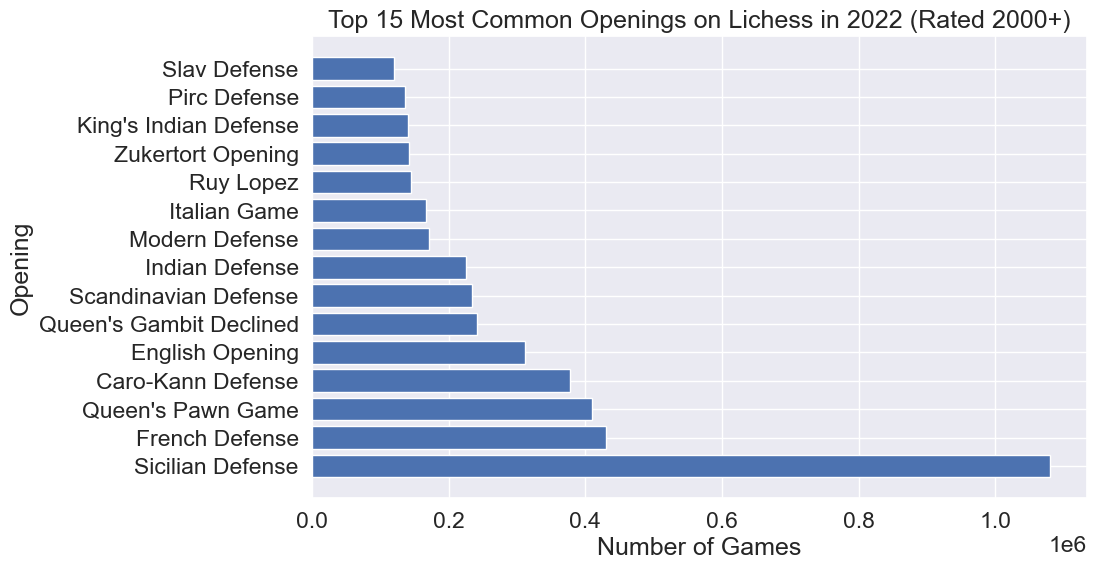

In [15]:
# Group variations of the same opening together by splitting on the colon.
high_rated_opening_groups = (
    df[df["WhiteElo"] >= 2000]["BaseOpening"].value_counts().compute()
)
display(high_rated_opening_groups)

# Calculate what proportion of all games the top 15 openings account for.
high_rated_top_15_openings = high_rated_opening_groups[:15]
high_rated_top_15_openings_proportion = (
    high_rated_top_15_openings.sum() / base_opening_counts.sum()
)
print(
    "The top 15 openings for players rated 2000+ account for "
    f"{high_rated_top_15_openings_proportion:.2%} of all games on Lichess in "
    "2022."
)

# Plot the top 15 most common openings.
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10, 6))
indexes = high_rated_opening_groups.index[:15]
values = high_rated_opening_groups.values[:15]
ax.barh(indexes, values)
ax.set_title("Top 15 Most Common Openings on Lichess in 2022 (Rated 2000+)")
ax.set_xlabel("Number of Games")
ax.set_ylabel("Opening")
plt.show()


### Mid Rated Players (Rating 1201-1999)


Sicilian Defense                     3144923
Queen's Pawn Game                    2406971
French Defense                       1594203
Italian Game                         1442963
Scandinavian Defense                 1414562
                                      ...   
Blumenfeld Countergambit Accepted         16
Formation                                 12
Dresden Opening                            6
Veresov Opening                            5
Amar Gambit                                2
Name: BaseOpening, Length: 162, dtype: int64

The top 15 openings for players rated 1201-1999 account for 45.47% of all games on Lichess in 2022.


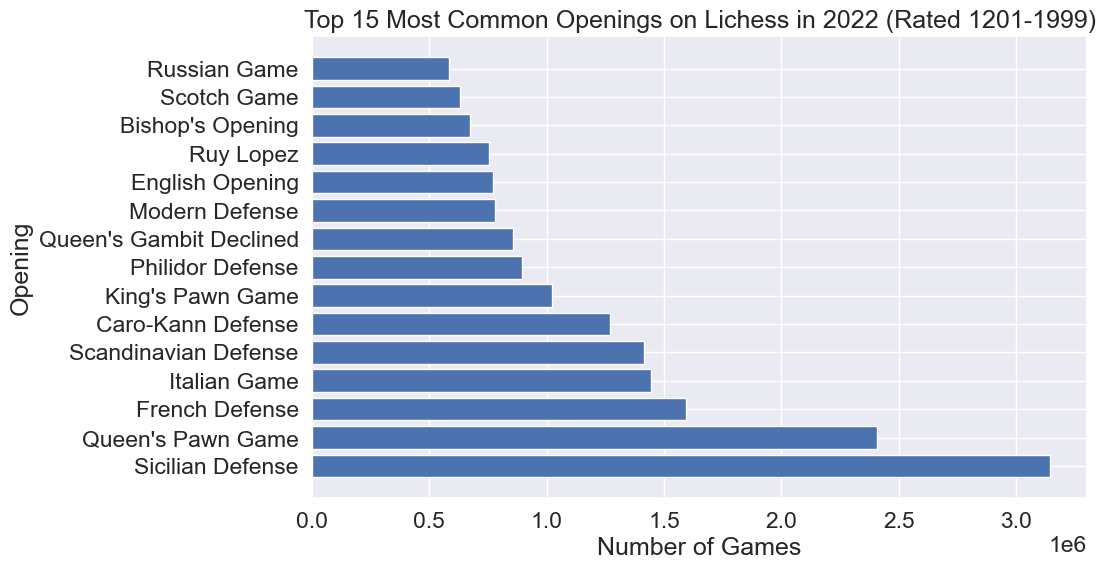

In [16]:
# Group variations of the same opening together by splitting on the colon.
mid_rated_opening_groups = (
    df[(df["WhiteElo"] >= 1201) & (df["WhiteElo"] <= 1999)]["BaseOpening"]
    .value_counts()
    .compute()
)
display(mid_rated_opening_groups)

# Calculate what proportion of all games the top 15 openings account for.
mid_rated_top_15_openings = mid_rated_opening_groups[:15]
mid_rated_top_15_openings_proportion = (
    mid_rated_top_15_openings.sum() / base_opening_counts.sum()
)
print(
    "The top 15 openings for players rated 1201-1999 account for "
    f"{mid_rated_top_15_openings_proportion:.2%} of all games on Lichess in 2022."
)

# Plot the top 15 most common openings.
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10, 6))
indexes = mid_rated_opening_groups.index[:15]
values = mid_rated_opening_groups.values[:15]
ax.barh(indexes, values)
ax.set_title("Top 15 Most Common Openings on Lichess in 2022 (Rated 1201-1999)")
ax.set_xlabel("Number of Games")
ax.set_ylabel("Opening")
plt.show()


### Low Rated Players (Rating 1200 and Below)


Queen's Pawn Game                         586993
King's Pawn Game                          583240
Scandinavian Defense                      330632
Sicilian Defense                          267560
Italian Game                              258579
                                           ...  
Veresov Opening                                2
Colle System                                   2
Amar Gambit                                    1
Queen's Pawn Game, Zukertort Variation         1
Marienbad System                               1
Name: BaseOpening, Length: 160, dtype: int64

The top 15 openings for players rated 1200 and below account for 8.95% of all games on Lichess in 2022.


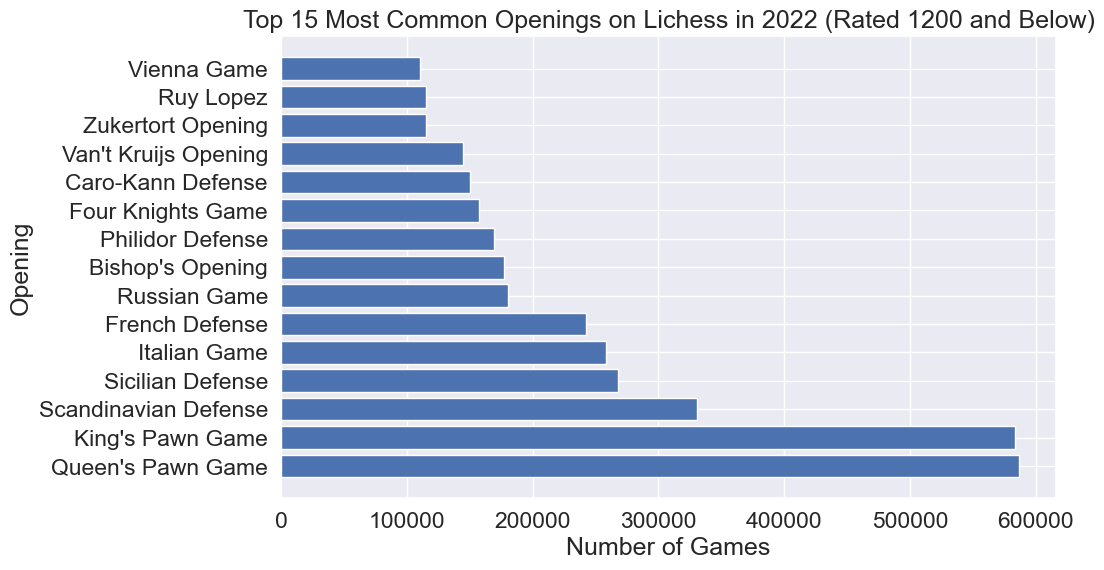

In [17]:
# Group variations of the same opening together by splitting on the colon.
low_rated_opening_groups = (
    df[df["WhiteElo"] <= 1200]["BaseOpening"].value_counts().compute()
)
display(low_rated_opening_groups)

# Calculate what proportion of all games the top 15 openings account for.
low_rated_top_15_openings = low_rated_opening_groups[:15]
low_rated_top_15_openings_proportion = (
    low_rated_top_15_openings.sum() / base_opening_counts.sum()
)
print(
    "The top 15 openings for players rated 1200 and below account for "
    f"{low_rated_top_15_openings_proportion:.2%} of all games on Lichess in 2022."
)

# Plot the top 15 most common openings.
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10, 6))
indexes = low_rated_opening_groups.index[:15]
values = low_rated_opening_groups.values[:15]
ax.barh(indexes, values)
ax.set_title("Top 15 Most Common Openings on Lichess in 2022 (Rated 1200 and Below)")
ax.set_xlabel("Number of Games")
ax.set_ylabel("Opening")
plt.show()


### Popularity of Sicilian Defense by Rating Group


In [18]:
num_games_sicilian_defense = base_opening_counts.loc["Sicilian Defense"]
print(f"Number of Games with Sicilian Defense: {num_games_sicilian_defense}")

# Calculate the number of games with Sicilian Defense in each rating bin.
sicilian_defense_df = df[df["BaseOpening"] == "Sicilian Defense"].compute()
rating_bins = np.arange(600, 3601, 200)
sicilian_defense_counts_by_rating = (
    sicilian_defense_df["WhiteElo"]
    .groupby(pd.cut(sicilian_defense_df["WhiteElo"], rating_bins))
    .count()
)
print("\nNumber of Games with Sicilian Defense by Rating Bin:")
display(sicilian_defense_counts_by_rating)

# Calculate the proportion of games with Sicilian Defense in each rating bin.
sicilian_defense_proportions_by_rating = (
    (sicilian_defense_counts_by_rating / merged_rating_counts) * 100
).round(2)
# Drop bins with fewer than 1000 games, as they're statistically insignificant.
reduced_sicilian_defense_proportions_by_rating = (
    sicilian_defense_proportions_by_rating.iloc[:-3]
)
print("\nProportion of Games (%) with Sicilian Defense by Rating Bin:")
display(reduced_sicilian_defense_proportions_by_rating)


Number of Games with Sicilian Defense: 4492781

Number of Games with Sicilian Defense by Rating Bin:


WhiteElo
(600, 800]         9538
(800, 1000]       61004
(1000, 1200]     196794
(1200, 1400]     421069
(1400, 1600]     707912
(1600, 1800]     981288
(1800, 2000]    1039368
(2000, 2200]     712764
(2200, 2400]     278572
(2400, 2600]      71255
(2600, 2800]      11740
(2800, 3000]       1230
(3000, 3200]         23
(3200, 3400]          0
(3400, 3600]          0
Name: WhiteElo, dtype: int64


Proportion of Games (%) with Sicilian Defense by Rating Bin:


WhiteElo
(600, 800]       1.39
(800, 1000]      1.93
(1000, 1200]     2.73
(1200, 1400]     3.74
(1400, 1600]     4.77
(1600, 1800]     6.07
(1800, 2000]     7.32
(2000, 2200]     8.34
(2200, 2400]     8.75
(2400, 2600]     8.71
(2600, 2800]     8.26
(2800, 3000]    10.58
dtype: float64

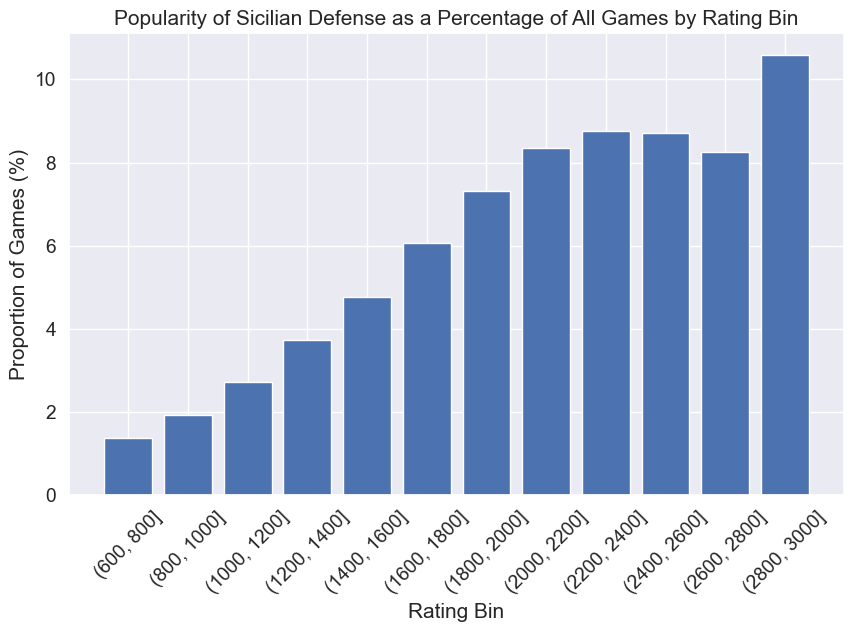

In [19]:
# Plot the popularity of the Sicilian Defense as a percentage of all games by
# rating bin.
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(10, 6))
indexes = reduced_sicilian_defense_proportions_by_rating.index.astype(str)
values = reduced_sicilian_defense_proportions_by_rating.values
ax.bar(indexes, values)
ax.set_title(
    "Popularity of Sicilian Defense as a Percentage of All Games by Rating Bin"
)
ax.set_xlabel("Rating Bin")
ax.set_ylabel("Proportion of Games (%)")
ax.set_xticklabels(indexes, rotation=45)
plt.show()


## Rating Difference


### Create Rating Difference Column


In [7]:
# Create an EloDiff column to represent the difference in Elo between the two
# players.
df["EloDiff"] = df["WhiteElo"] - df["BlackElo"]
# Calculate the relative rating difference of White to Black as a percentage.
df["RelativeEloDiff"] = (
    ((df["WhiteElo"] / (df[["WhiteElo", "BlackElo"]].median(axis=1))) - 1.0) * 100.0
).round(2)
display(df.head())


,UTCDateTime,Event,TimeControl,Result,Termination,ECO,Opening,White,Black,WhiteElo,BlackElo,Site,BaseOpening,EloDiff,RelativeEloDiff
0,2022-01-01 00:00:11,Rated Rapid game,600+0,1-0,Normal,B00,"Nimzowitsch Defense: Scandinavian Variation, A...",shahzad97,mpasha98,1500,1205,https://lichess.org/UMMGcaGz,Nimzowitsch Defense,295,10.91
1,2022-01-01 00:00:11,Rated Blitz game,300+3,0-1,Normal,D00,Queen's Pawn Game: Mason Variation,nicolas_clos,pangma,1430,1412,https://lichess.org/yJI78ET0,Queen's Pawn Game,18,0.63
2,2022-01-01 00:00:12,Rated Blitz game,300+0,1-0,Normal,E97,"King's Indian Defense: Orthodox Variation, Aro...",oyuka79,JUAN121,2422,2292,https://lichess.org/mrPOJU0W,King's Indian Defense,130,2.76
3,2022-01-01 00:00:12,Rated Blitz game,300+0,1-0,Normal,C22,Center Game: Berger Variation,manoharkatwa,RigoBam,1241,1221,https://lichess.org/YJ1AIn03,Center Game,20,0.81
4,2022-01-01 00:00:12,Rated Blitz game,300+0,0-1,Time forfeit,A40,Modern Defense,raffrantic1,Carly001,1044,1091,https://lichess.org/RATgKCCm,Modern Defense,-47,-2.20


### Effect of Higher Rating on White Win Rate


In [21]:
# Count the outcomes of all games.
outcomes = df["Result"].value_counts().compute()
print("Results of All Games:")
display(outcomes)
# Calculate how often White won and lost in all games.
num_white_wins = outcomes.loc["1-0"]
white_wins_proportion = num_white_wins / outcomes.sum()
num_white_losses = outcomes.loc["0-1"]
white_losses_proportion = num_white_losses / outcomes.sum()
print(
    f"Out of {outcomes.sum()} games:\n  White won {num_white_wins} games "
    f"({white_wins_proportion:.2%}).\n  White lost {num_white_losses} games "
    f"({white_losses_proportion:.2%})."
)

# Count the outcomes of games where White had a higher rating.
higher_white_outcomes = df[df["EloDiff"] > 0]["Result"].value_counts().compute()
print("\n\nResults of Games When White Had a Higher Rating:")
display(higher_white_outcomes)
# Calculate how often White won and lost when they had a higher rating.
num_higher_white_wins = higher_white_outcomes.loc["1-0"]
higher_white_wins_proportion = num_higher_white_wins / higher_white_outcomes.sum()
num_higher_white_losses = higher_white_outcomes.loc["0-1"]
higher_white_losses_proportion = num_higher_white_losses / higher_white_outcomes.sum()
print(
    f"Out of {higher_white_outcomes.sum()} games when White had a higher rating:\n  "
    f"White won {num_higher_white_wins} games ({higher_white_wins_proportion:.2%}).\n  "
    f"White lost {num_higher_white_losses} games ({higher_white_losses_proportion:.2%})."
)


Results of All Games:


1-0        19938052
0-1        18450502
1/2-1/2     1733174
Name: Result, dtype: int64

Out of 40121728 games:
  White won 19938052 games (49.69%).
  White lost 18450502 games (45.99%).


Results of Games When White Had a Higher Rating:


1-0        10662552
0-1         8242031
1/2-1/2      846503
Name: Result, dtype: int64

Out of 19751086 games when White had a higher rating:
  White won 10662552 games (53.98%).
  White lost 8242031 games (41.73%).


### Effect of Absolute Rating Difference on White Win Rate


In [48]:
# Count the different RelativeEloDiff values.
elo_diff_counts = df["EloDiff"].value_counts().compute()
# Get the minimum, maximum, mean, and median RelativeEloDiff values.
elo_diffs_min = np.min(elo_diff_counts.index)
elo_diffs_max = np.max(elo_diff_counts.index)
elo_diffs_mean = np.mean(elo_diff_counts.index)
elo_diffs_median = np.median(elo_diff_counts.index)
print(
    f"EloDiff:\n  Min: {elo_diffs_min}\n  "
    f"Max: {elo_diffs_max}\n  "
    f"Mean: {elo_diffs_mean:.2f}\n  "
    f"Median: {elo_diffs_median}"
)

# Bin the EloDiff values.
elo_diff_bins = np.arange(-2200, 2201, 100)
# Create a new column that says what EloDiff bin each game belongs to.
df = df.map_partitions(
    lambda df: df.assign(
        EloDiffBin=lambda df: pd.cut(df["EloDiff"], bins=elo_diff_bins)
    )
)
display(df[["EloDiff", "EloDiffBin"]].head())

# Count the number of games in each bin.
elo_diff_counts.index = pd.cut(elo_diff_counts.index, bins=elo_diff_bins)
merged_elo_diff_counts = elo_diff_counts.groupby(level=0).sum()
# Remove the bins with fewer than 1000 games.
reduced_merged_elo_diff_counts = merged_elo_diff_counts.iloc[9:-10]

print("\nNumber of Games in Each EloDiff Bin:")
display(merged_elo_diff_counts)


EloDiff:
  Min: -2106
  Max: 2106
  Mean: -4.37
  Median: -3.5


,EloDiff,EloDiffBin
0,295,"(200, 300]"
1,18,"(0, 100]"
2,130,"(100, 200]"
3,20,"(0, 100]"
4,-47,"(-100, 0]"



Number of Games in Each EloDiff Bin:


(-2200, -2100]           2
(-2100, -2000]           1
(-2000, -1900]           8
(-1900, -1800]          18
(-1800, -1700]          57
(-1700, -1600]          93
(-1600, -1500]         159
(-1500, -1400]         300
(-1400, -1300]         627
(-1300, -1200]        1017
(-1200, -1100]        1925
(-1100, -1000]        2729
(-1000, -900]         4399
(-900, -800]          7082
(-800, -700]         10925
(-700, -600]         16938
(-600, -500]         28098
(-500, -400]         85380
(-400, -300]        132263
(-300, -200]        222804
(-200, -100]       1688710
(-100, 0]         18167107
(0, 100]          17578324
(100, 200]         1654873
(200, 300]          226169
(300, 400]          132221
(400, 500]           85519
(500, 600]           27931
(600, 700]           17006
(700, 800]           10806
(800, 900]            7232
(900, 1000]           4323
(1000, 1100]          2735
(1100, 1200]          1745
(1200, 1300]           983
(1300, 1400]           609
(1400, 1500]           313
(

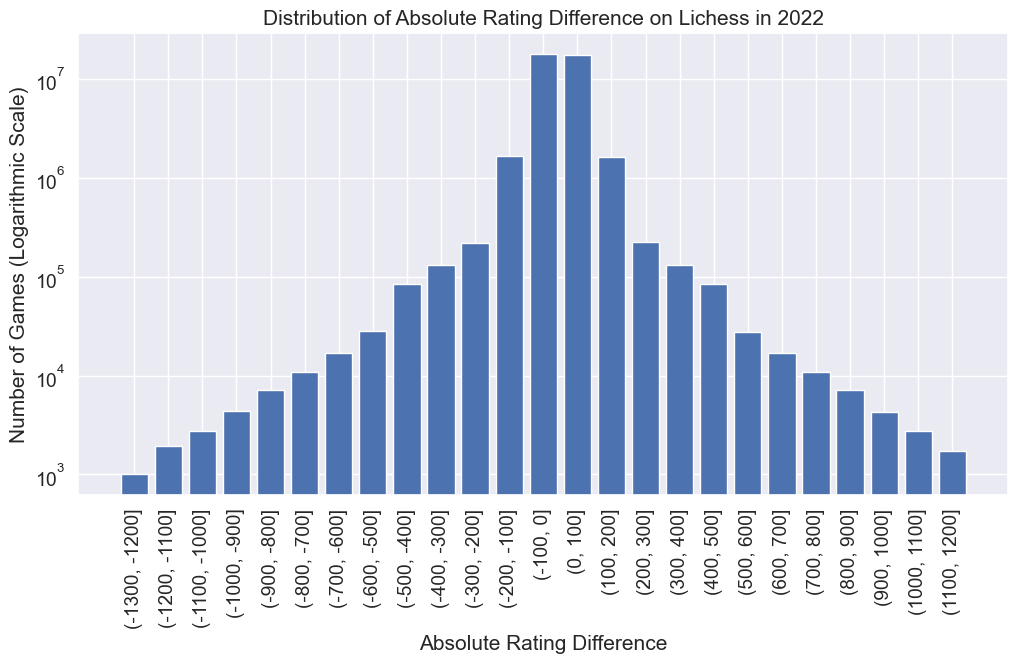

In [23]:
# Graph the number of games in each RelativeEloDiff bin.
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(12, 6))
indexes = reduced_merged_elo_diff_counts.index.astype(str)
values = reduced_merged_elo_diff_counts.values
ax.bar(indexes, values)
ax.set_title("Distribution of Absolute Rating Difference on Lichess in 2022")
ax.set_xlabel("Absolute Rating Difference")
ax.set_ylabel("Number of Games (Logarithmic Scale)")
ax.set_yscale("log")
ax.set_xticklabels(indexes, rotation=90)
plt.show()


In [24]:
# Count the number of games where White won in each RelativeEloDiff bin.
elo_diff_wins = df[df["Result"] == "1-0"]["EloDiff"].value_counts().compute()
elo_diff_wins.index = pd.cut(elo_diff_wins.index, bins=elo_diff_bins)
merged_elo_diff_wins = elo_diff_wins.groupby(level=0).sum()
print("Number of Games Where White Won in Each EloDiff Bin:")
display(merged_elo_diff_wins)

# Calculate the proportion of games where White won in each EloDiff bin.
merged_elo_diff_win_rates = (
    (merged_elo_diff_wins / merged_elo_diff_counts) * 100.0
).round(2)
# Remove the bins with fewer than 1000 games.
reduced_merged_elo_diff_win_rates = merged_elo_diff_win_rates.iloc[9:-10]
print("Win Rate (%) for White in Each EloDiff Bin:")
display(reduced_merged_elo_diff_win_rates)


Number of Games Where White Won in Each EloDiff Bin:


(-2200, -2100]          0
(-2100, -2000]          0
(-2000, -1900]          1
(-1900, -1800]          0
(-1800, -1700]         12
(-1700, -1600]         11
(-1600, -1500]         24
(-1500, -1400]         35
(-1400, -1300]         45
(-1300, -1200]         88
(-1200, -1100]        207
(-1100, -1000]        307
(-1000, -900]         516
(-900, -800]         1001
(-800, -700]         1572
(-700, -600]         2734
(-600, -500]         5005
(-500, -400]        14318
(-400, -300]        27434
(-300, -200]        59932
(-200, -100]       627715
(-100, 0]         8534543
(0, 100]          9247346
(100, 200]        1023192
(200, 300]         160227
(300, 400]         102045
(400, 500]          69540
(500, 600]          22236
(600, 700]          13683
(700, 800]           8843
(800, 900]           6051
(900, 1000]          3630
(1000, 1100]         2333
(1100, 1200]         1522
(1200, 1300]          852
(1300, 1400]          551
(1400, 1500]          257
(1500, 1600]          140
(1600, 1700]

Win Rate (%) for White in Each EloDiff Bin:


(-1300, -1200]     8.65
(-1200, -1100]    10.75
(-1100, -1000]    11.25
(-1000, -900]     11.73
(-900, -800]      14.13
(-800, -700]      14.39
(-700, -600]      16.14
(-600, -500]      17.81
(-500, -400]      16.77
(-400, -300]      20.74
(-300, -200]      26.90
(-200, -100]      37.17
(-100, 0]         46.98
(0, 100]          52.61
(100, 200]        61.83
(200, 300]        70.84
(300, 400]        77.18
(400, 500]        81.32
(500, 600]        79.61
(600, 700]        80.46
(700, 800]        81.83
(800, 900]        83.67
(900, 1000]       83.97
(1000, 1100]      85.30
(1100, 1200]      87.22
Name: EloDiff, dtype: float64

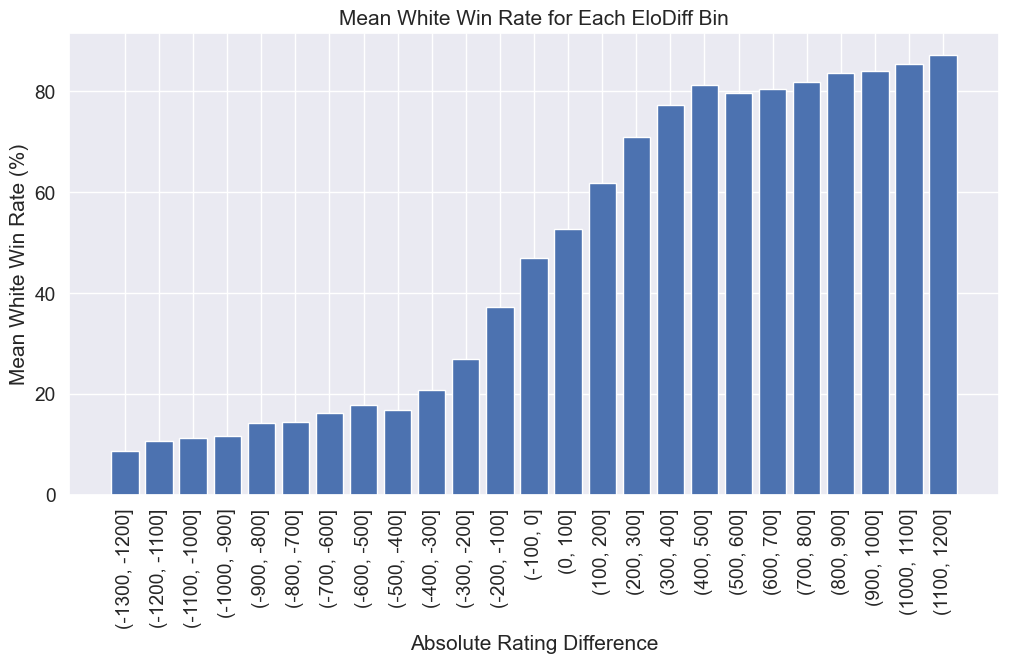

In [25]:
# Plot the mean win rate for White in each EloDiff bin.
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(12, 6))
# Plot the mean win rate for White in each EloDiff bin.
indexes = reduced_merged_elo_diff_win_rates.index.astype(str)
values = reduced_merged_elo_diff_win_rates.values
ax.bar(indexes, values)
ax.set_title("Mean White Win Rate for Each EloDiff Bin")
ax.set_xlabel("Absolute Rating Difference")
ax.set_ylabel("Mean White Win Rate (%)")
ax.set_xticklabels(indexes, rotation=90)
plt.show()


### Effect of Relative Rating Difference on White Win Rate


In [50]:
# Count the different RelativeEloDiff values.
relative_elo_diff_counts = df["RelativeEloDiff"].value_counts().compute()
# Get the minimum, maximum, mean, and median RelativeEloDiff values.
relative_elo_diffs_min = np.min(relative_elo_diff_counts.index)
relative_elo_diffs_max = np.max(relative_elo_diff_counts.index)
relative_elo_diffs_mean = np.mean(relative_elo_diff_counts.index)
relative_elo_diffs_median = np.median(relative_elo_diff_counts.index)
print(
    f"RelativeEloDiff:\n  Min: {relative_elo_diffs_min}\n  "
    f"Max: {relative_elo_diffs_max}\n  "
    f"Mean: {relative_elo_diffs_mean:.2f}\n  "
    f"Median: {relative_elo_diffs_median}"
)

# Bin the RelativeEloDiff values.
relative_elo_diff_bins = np.arange(-60, 61, 10)
# Create a new column that says what RelativeEloDiff bin each game belongs to.
df = df.map_partitions(
    lambda df: df.assign(
        RelativeEloDiffBin=lambda df: pd.cut(
            df["RelativeEloDiff"], bins=relative_elo_diff_bins
        )
    )
)
display(df[["RelativeEloDiff", "RelativeEloDiffBin"]].head())

# Count the number of games in each bin.
relative_elo_diff_counts.index = pd.cut(
    relative_elo_diff_counts.index, bins=relative_elo_diff_bins
)
merged_relative_elo_diff_counts = relative_elo_diff_counts.groupby(level=0).sum()

# Remove the bins with fewer than 1000 games.
reduced_merged_relative_elo_diff_counts = merged_relative_elo_diff_counts.iloc[1:-1]
print("\nNumber of Games in Each RelativeEloDiff Bin:")
display(reduced_merged_relative_elo_diff_counts)


RelativeEloDiff:
  Min: -62.59
  Max: 62.89
  Mean: -0.13
  Median: -0.14500000000000002


,RelativeEloDiff,RelativeEloDiffBin
0,10.91,"(10, 20]"
1,0.63,"(0, 10]"
2,2.76,"(0, 10]"
3,0.81,"(0, 10]"
4,-2.20,"(-10, 0]"



Number of Games in Each RelativeEloDiff Bin:


(-50, -40]        2773
(-40, -30]       10269
(-30, -20]       39507
(-20, -10]      238650
(-10, 0]      20078939
(0, 10]       19456414
(10, 20]        241485
(20, 30]         39591
(30, 40]         10369
(40, 50]          2753
Name: RelativeEloDiff, dtype: int64

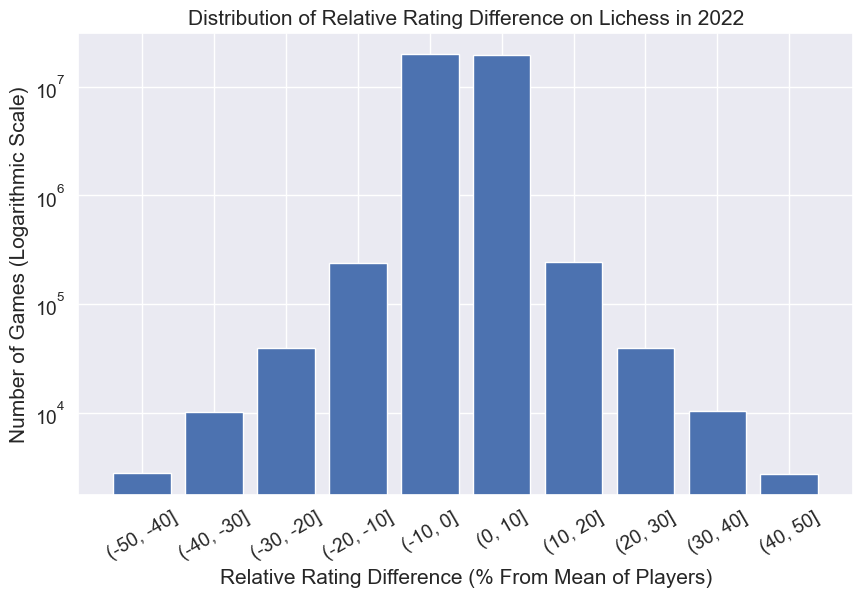

In [27]:
# Graph the number of games in each RelativeEloDiff bin.
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(10, 6))
indexes = reduced_merged_relative_elo_diff_counts.index.astype(str)
values = reduced_merged_relative_elo_diff_counts.values
ax.bar(indexes, values)
ax.set_title("Distribution of Relative Rating Difference on Lichess in 2022")
ax.set_xlabel(f"Relative Rating Difference (% From Mean of Players)")
ax.set_ylabel("Number of Games (Logarithmic Scale)")
ax.set_yscale("log")
ax.set_xticklabels(indexes, rotation=30)
plt.show()


In [28]:
# Count the number of games where White won in each RelativeEloDiff bin.
relative_elo_diff_wins = (
    df[df["Result"] == "1-0"]["RelativeEloDiff"].value_counts().compute()
)
relative_elo_diff_wins.index = pd.cut(
    relative_elo_diff_wins.index, bins=relative_elo_diff_bins
)
merged_relative_elo_diff_wins = relative_elo_diff_wins.groupby(level=0).sum()
print("Number of Games Where White Won in Each RelativeEloDiff Bin:")
display(merged_relative_elo_diff_wins)

# Calculate the proportion of games where White won in each RelativeEloDiff
# bin.
merged_relative_elo_diff_win_rates = (
    (merged_relative_elo_diff_wins / merged_relative_elo_diff_counts) * 100.0
).round(2)
# Remove the bins with fewer than 1000 games.
reduced_merged_relative_elo_diff_win_rates = merged_relative_elo_diff_win_rates.iloc[
    1:-1
]
print("Win Rate (%) for White in Each RelativeEloDiff Bin:")
display(reduced_merged_relative_elo_diff_win_rates)


Number of Games Where White Won in Each RelativeEloDiff Bin:


(-60, -50]          63
(-50, -40]         309
(-40, -30]        1323
(-30, -20]        6363
(-20, -10]       49263
(-10, 0]       9218179
(0, 10]       10432625
(10, 20]        186534
(20, 30]         31935
(30, 40]          8683
(40, 50]          2369
(50, 60]           401
Name: RelativeEloDiff, dtype: int64

Win Rate (%) for White in Each RelativeEloDiff Bin:


(-50, -40]    11.14
(-40, -30]    12.88
(-30, -20]    16.11
(-20, -10]    20.64
(-10, 0]      45.91
(0, 10]       53.62
(10, 20]      77.24
(20, 30]      80.66
(30, 40]      83.74
(40, 50]      86.05
Name: RelativeEloDiff, dtype: float64

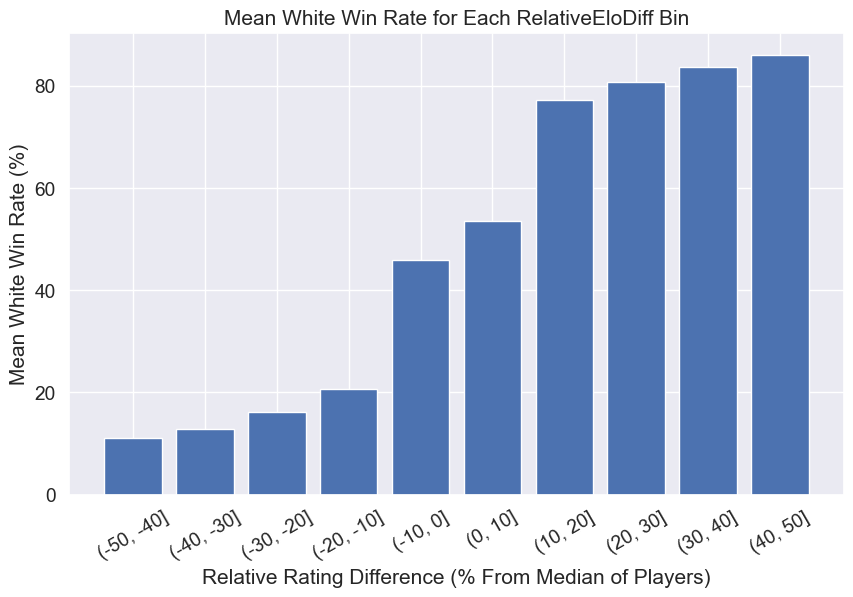

In [29]:
# Plot the mean win rate for White in each RelativeEloDiff bin.
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the mean win rate for White in each RelativeEloDiff bin.
indexes = reduced_merged_relative_elo_diff_win_rates.index.astype(str)
values = reduced_merged_relative_elo_diff_win_rates.values
ax.bar(indexes, values)
ax.set_title("Mean White Win Rate for Each RelativeEloDiff Bin")
ax.set_xlabel(f"Relative Rating Difference (% From Median of Players)")
ax.set_ylabel("Mean White Win Rate (%)")
ax.set_xticklabels(indexes, rotation=30)
plt.show()


## Subsample the Data for Machine Learning Models


In [8]:
# Subsample the data to 12.5% of its original size - around 5 million games.
df_reduced = df.sample(frac=0.125, random_state=69)
display(df_reduced.head())
print(f"Subsampled the data to {len(df_reduced)} games.")


,UTCDateTime,Event,TimeControl,Result,Termination,ECO,Opening,White,Black,WhiteElo,BlackElo,Site,BaseOpening,EloDiff,RelativeEloDiff
311983,2022-01-01 07:50:07,Rated Blitz game,180+2,1-0,Normal,D00,Queen's Pawn Game: Mason Variation,danielho81,geniusschess,1796,1794,https://lichess.org/j573biCn,Queen's Pawn Game,2,0.06
31845,2022-01-01 00:37:37,Rated Blitz game,180+0,0-1,Normal,C50,Giuoco Piano,Mccduarte,RonzaDeMamba,2010,2016,https://lichess.org/L0hJSSz8,Giuoco Piano,-6,-0.15
122340,2022-01-01 02:47:02,Rated Blitz game,180+2,0-1,Normal,A00,Mieses Opening,Kaufmamovic,Periostio,1972,2063,https://lichess.org/jIj1gjA4,Mieses Opening,-91,-2.26
81433,2022-01-01 01:43:48,Rated Blitz game,0+6,0-1,Normal,B06,Modern Defense,zamurdnisa1,Medel22,1692,1908,https://lichess.org/zd1mfNyL,Modern Defense,-216,-6.00
266131,2022-01-01 06:48:16,Rated Blitz game,180+2,0-1,Time forfeit,D80,Grünfeld Defense: Stockholm Variation,rishy_g20,alpesh36,1710,1673,https://lichess.org/u2QDcYFT,Grünfeld Defense,37,1.09


Subsampled the data to 5015218 games.


## Predict the Result of a Game


### Decision Tree Classifier


#### Baseline Model – Only RelativeEloDiffBin


In [8]:
# Re-bin the RelativeEloDiff values into more precise bins to improve the
# model's efficacy.
relative_elo_diff_bins = np.arange(-60, 61, 5)
# Create a new column that says what RelativeEloDiff bin each game belongs to.
df_reduced = df_reduced.map_partitions(
    lambda df_reduced: df_reduced.assign(
        RelativeEloDiffBin=lambda df_reduced: pd.cut(
            df_reduced["RelativeEloDiff"], bins=relative_elo_diff_bins
        )
    )
)
display(df_reduced[["RelativeEloDiff", "RelativeEloDiffBin"]].head())

# Select features.
X = df_reduced[["RelativeEloDiffBin"]].compute()
y = df_reduced["Result"].compute()

# Encode categorical features to numerical using one-hot encoding.
X = pd.get_dummies(X)

# Split the data into training and test sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Create and fit the decision tree classifier.
clf = DecisionTreeClassifier(random_state=69)
clf.fit(X, y)

# Make predictions on the test set.
y_pred = clf.predict(X_test)
# Evaluate the model's performance.
acc = accuracy_score(y_test, y_pred)
display(f"Accuracy of the decision tree classifier: {acc:.3f}")
f1 = f1_score(y_test, y_pred, average="weighted")
display(f"F1 score of the decision tree classifier: {f1:.3f}")


,RelativeEloDiff,RelativeEloDiffBin
311983,0.06,"(0, 5]"
31845,-0.15,"(-5, 0]"
122340,-2.26,"(-5, 0]"
81433,-6.00,"(-10, -5]"
266131,1.09,"(0, 5]"


'Accuracy of the decision tree classifier: 0.520'

'F1 score of the decision tree classifier: 0.509'

#### BaseOpening, WhiteElo, and BlackElo


In [35]:
# Select features.
X = df_reduced[["BaseOpening", "WhiteElo", "BlackElo"]].compute()
y = df_reduced["Result"].compute()

# Encode categorical features to numerical using one-hot encoding.
X = pd.get_dummies(X)

# Split the data into training and test sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Create and fit the decision tree classifier.
clf = DecisionTreeClassifier(random_state=69)
clf.fit(X, y)

# Make predictions on the test set.
y_pred = clf.predict(X_test)
# Evaluate the model's performance.
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy of the decision tree classifier: {acc:.3f}")
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"F1 score of the decision tree classifier: {f1:.3f}")


Accuracy of the decision tree classifier: 0.476
F1 score of the decision tree classifier: 0.474


#### BaseOpening and RelativeEloDiff


In [36]:
# Select features.
X = df_reduced[["BaseOpening", "RelativeEloDiff"]].compute()
y = df_reduced["Result"].compute()

# Encode categorical features to numerical using one-hot encoding.
X = pd.get_dummies(X)

# Split the data into training and test sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Create and fit the decision tree classifier.
clf = DecisionTreeClassifier(random_state=69)
clf.fit(X, y)

# Make predictions on the test set.
y_pred = clf.predict(X_test)
# Evaluate the model's performance.
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy of the decision tree classifier: {acc:.3f}")
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"F1 score of the decision tree classifier: {f1:.3f}")


Accuracy of the decision tree classifier: 0.511
F1 score of the decision tree classifier: 0.492


#### BaseOpening, RelativeEloDiff, WhiteElo, and BlackElo


In [38]:
# Select features.
X = df_reduced[["BaseOpening", "RelativeEloDiff", "WhiteElo", "BlackElo"]].compute()
y = df_reduced["Result"].compute()

# Encode categorical features to numerical using one-hot encoding.
X = pd.get_dummies(X)

# Split the data into training and test sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Create and fit the decision tree classifier.
clf = DecisionTreeClassifier(random_state=69)
clf.fit(X, y)

# Make predictions on the test set.
y_pred = clf.predict(X_test)
# Evaluate the model's performance.
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy of the decision tree classifier: {acc:.3f}")
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"F1 score of the decision tree classifier: {f1:.3f}")


Accuracy of the decision tree classifier: 0.476
F1 score of the decision tree classifier: 0.473


#### BaseOpening, RelativeEloDiff, and TimeControl


In [39]:
# Select features.
X = df_reduced[["BaseOpening", "RelativeEloDiff", "TimeControl"]].compute()
y = df_reduced["Result"].compute()

# Encode categorical features to numerical using one-hot encoding.
X = pd.get_dummies(X)

# Split the data into training and test sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Create and fit the decision tree classifier.
clf = DecisionTreeClassifier(random_state=69)
clf.fit(X, y)

# Make predictions on the test set.
y_pred = clf.predict(X_test)
# Evaluate the model's performance.
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy of the decision tree classifier: {acc:.3f}")
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"F1 score of the decision tree classifier: {f1:.3f}")


Accuracy of the decision tree classifier: 0.496
F1 score of the decision tree classifier: 0.486


#### BaseOpening and RelativeEloDiffBin (10% Increments)


In [70]:
relative_elo_diff_bins = np.arange(-60, 61, 10)
# Create a new column that says what RelativeEloDiff bin each game belongs to.
df_reduced = df_reduced.map_partitions(
    lambda df_reduced: df_reduced.assign(
        RelativeEloDiffBin=lambda df_reduced: pd.cut(
            df_reduced["RelativeEloDiff"], bins=relative_elo_diff_bins
        )
    )
)
display(df_reduced[["RelativeEloDiff", "RelativeEloDiffBin"]].head())

# Select features.
X = df_reduced[["BaseOpening", "RelativeEloDiffBin"]].compute()
y = df_reduced["Result"].compute()

# Encode categorical features to numerical using one-hot encoding.
X = pd.get_dummies(X)

# Split the data into training and test sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Create and fit the decision tree classifier.
clf = DecisionTreeClassifier(random_state=69)
clf.fit(X, y)

# Make predictions on the test set.
y_pred = clf.predict(X_test)
# Evaluate the model's performance.
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy of the decision tree classifier: {acc:.3f}")
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"F1 score of the decision tree classifier: {f1:.3f}")


,RelativeEloDiff,RelativeEloDiffBin
311983,0.06,"(0, 10]"
31845,-0.15,"(-10, 0]"
122340,-2.26,"(-10, 0]"
81433,-6.00,"(-10, 0]"
266131,1.09,"(0, 10]"


Accuracy of the decision tree classifier: 0.521
F1 score of the decision tree classifier: 0.509


#### BaseOpening and RelativeEloDiffBin (5% Increments)


In [61]:
# Re-bin the RelativeEloDiff values into more precise bins to improve the
# model's efficacy.
relative_elo_diff_bins = np.arange(-60, 61, 5)
# Create a new column that says what RelativeEloDiff bin each game belongs to.
df_reduced = df_reduced.map_partitions(
    lambda df_reduced: df_reduced.assign(
        RelativeEloDiffBin=lambda df_reduced: pd.cut(
            df_reduced["RelativeEloDiff"], bins=relative_elo_diff_bins
        )
    )
)
display(df_reduced[["RelativeEloDiff", "RelativeEloDiffBin"]].head())

# Select features.
X = df_reduced[["BaseOpening", "RelativeEloDiffBin"]].compute()
y = df_reduced["Result"].compute()

# Encode categorical features to numerical using one-hot encoding.
X = pd.get_dummies(X)

# Split the data into training and test sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Create and fit the decision tree classifier.
clf = DecisionTreeClassifier(random_state=69)
clf.fit(X, y)

# Make predictions on the test set.
y_pred = clf.predict(X_test)
# Evaluate the model's performance.
acc = accuracy_score(y_test, y_pred)
display(f"Accuracy of the decision tree classifier: {acc:.3f}")
f1 = f1_score(y_test, y_pred, average="weighted")
display(f"F1 score of the decision tree classifier: {f1:.3f}")


,RelativeEloDiff,RelativeEloDiffBin
311983,0.06,"(0, 5]"
31845,-0.15,"(-5, 0]"
122340,-2.26,"(-5, 0]"
81433,-6.00,"(-10, -5]"
266131,1.09,"(0, 5]"


'Accuracy of the decision tree classifier: 0.521'

'F1 score of the decision tree classifier: 0.510'

#### BaseOpening and RelativeEloDiffBin (2% Increments)


In [62]:
# Re-bin the RelativeEloDiff values into more precise bins to improve the
# model's efficacy.
relative_elo_diff_bins = np.arange(-60, 61, 2)
# Create a new column that says what RelativeEloDiff bin each game belongs to.
df_reduced = df_reduced.map_partitions(
    lambda df_reduced: df_reduced.assign(
        RelativeEloDiffBin=lambda df_reduced: pd.cut(
            df_reduced["RelativeEloDiff"], bins=relative_elo_diff_bins
        )
    )
)
display(df_reduced[["RelativeEloDiff", "RelativeEloDiffBin"]].head())

# Select features.
X = df_reduced[["BaseOpening", "RelativeEloDiffBin"]].compute()
y = df_reduced["Result"].compute()

# Encode categorical features to numerical using one-hot encoding.
X = pd.get_dummies(X)

# Split the data into training and test sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Create and fit the decision tree classifier.
clf = DecisionTreeClassifier(random_state=69)
clf.fit(X, y)

# Make predictions on the test set.
y_pred = clf.predict(X_test)
# Evaluate the model's performance.
acc = accuracy_score(y_test, y_pred)
display(f"Accuracy of the decision tree classifier: {acc:.3f}")
f1 = f1_score(y_test, y_pred, average="weighted")
display(f"F1 score of the decision tree classifier: {f1:.3f}")


,RelativeEloDiff,RelativeEloDiffBin
311983,0.06,"(0, 2]"
31845,-0.15,"(-2, 0]"
122340,-2.26,"(-4, -2]"
81433,-6.00,"(-8, -6]"
266131,1.09,"(0, 2]"


'Accuracy of the decision tree classifier: 0.524'

'F1 score of the decision tree classifier: 0.502'

#### BaseOpening and RelativeEloDiffBin (1% Increments)


In [63]:
# Re-bin the RelativeEloDiff values into more precise bins to improve the
# model's efficacy.
relative_elo_diff_bins = np.arange(-60, 61, 1)
# Create a new column that says what RelativeEloDiff bin each game belongs to.
df_reduced = df_reduced.map_partitions(
    lambda df_reduced: df_reduced.assign(
        RelativeEloDiffBin=lambda df_reduced: pd.cut(
            df_reduced["RelativeEloDiff"], bins=relative_elo_diff_bins
        )
    )
)
display(df_reduced[["RelativeEloDiff", "RelativeEloDiffBin"]].head())

# Select features.
X = df_reduced[["BaseOpening", "RelativeEloDiffBin"]].compute()
y = df_reduced["Result"].compute()

# Encode categorical features to numerical using one-hot encoding.
X = pd.get_dummies(X)

# Split the data into training and test sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Create and fit the decision tree classifier.
clf = DecisionTreeClassifier(random_state=69)
clf.fit(X, y)

# Make predictions on the test set.
y_pred = clf.predict(X_test)
# Evaluate the model's performance.
acc = accuracy_score(y_test, y_pred)
display(f"Accuracy of the decision tree classifier: {acc:.3f}")
f1 = f1_score(y_test, y_pred, average="weighted")
display(f"F1 score of the decision tree classifier: {f1:.3f}")


,RelativeEloDiff,RelativeEloDiffBin
311983,0.06,"(0, 1]"
31845,-0.15,"(-1, 0]"
122340,-2.26,"(-3, -2]"
81433,-6.00,"(-7, -6]"
266131,1.09,"(1, 2]"


'Accuracy of the decision tree classifier: 0.525'

'F1 score of the decision tree classifier: 0.503'

#### BaseOpening and RelativeEloDiffBin (0.5% Increments)


In [65]:
# Re-bin the RelativeEloDiff values into more precise bins to improve the
# model's efficacy.
relative_elo_diff_bins = np.arange(-60, 61, 0.5)
# Create a new column that says what RelativeEloDiff bin each game belongs to.
df_reduced = df_reduced.map_partitions(
    lambda df_reduced: df_reduced.assign(
        RelativeEloDiffBin=lambda df_reduced: pd.cut(
            df_reduced["RelativeEloDiff"], bins=relative_elo_diff_bins
        )
    )
)
display(df_reduced[["RelativeEloDiff", "RelativeEloDiffBin"]].head())

# Select features.
X = df_reduced[["BaseOpening", "RelativeEloDiffBin"]].compute()
y = df_reduced["Result"].compute()

# Encode categorical features to numerical using one-hot encoding.
X = pd.get_dummies(X)

# Split the data into training and test sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Create and fit the decision tree classifier.
clf = DecisionTreeClassifier(random_state=69)
clf.fit(X, y)

# Make predictions on the test set.
y_pred = clf.predict(X_test)
# Evaluate the model's performance.
acc = accuracy_score(y_test, y_pred)
display(f"Accuracy of the decision tree classifier: {acc:.3f}")
f1 = f1_score(y_test, y_pred, average="weighted")
display(f"F1 score of the decision tree classifier: {f1:.3f}")


,RelativeEloDiff,RelativeEloDiffBin
311983,0.06,"(0.0, 0.5]"
31845,-0.15,"(-0.5, 0.0]"
122340,-2.26,"(-2.5, -2.0]"
81433,-6.00,"(-6.5, -6.0]"
266131,1.09,"(1.0, 1.5]"


'Accuracy of the decision tree classifier: 0.525'

'F1 score of the decision tree classifier: 0.496'

#### BaseOpening and RelativeEloDiffBin (0.25% Increments)


In [64]:
# Re-bin the RelativeEloDiff values into more precise bins to improve the
# model's efficacy.
relative_elo_diff_bins = np.arange(-60, 61, 0.25)
# Create a new column that says what RelativeEloDiff bin each game belongs to.
df_reduced = df_reduced.map_partitions(
    lambda df_reduced: df_reduced.assign(
        RelativeEloDiffBin=lambda df_reduced: pd.cut(
            df_reduced["RelativeEloDiff"], bins=relative_elo_diff_bins
        )
    )
)
display(df_reduced[["RelativeEloDiff", "RelativeEloDiffBin"]].head())

# Select features.
X = df_reduced[["BaseOpening", "RelativeEloDiffBin"]].compute()
y = df_reduced["Result"].compute()

# Encode categorical features to numerical using one-hot encoding.
X = pd.get_dummies(X)

# Split the data into training and test sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Create and fit the decision tree classifier.
clf = DecisionTreeClassifier(random_state=69)
clf.fit(X, y)

# Make predictions on the test set.
y_pred = clf.predict(X_test)
# Evaluate the model's performance.
acc = accuracy_score(y_test, y_pred)
display(f"Accuracy of the decision tree classifier: {acc:.3f}")
f1 = f1_score(y_test, y_pred, average="weighted")
display(f"F1 score of the decision tree classifier: {f1:.3f}")


,RelativeEloDiff,RelativeEloDiffBin
311983,0.06,"(0.0, 0.25]"
31845,-0.15,"(-0.25, 0.0]"
122340,-2.26,"(-2.5, -2.25]"
81433,-6.00,"(-6.25, -6.0]"
266131,1.09,"(1.0, 1.25]"


'Accuracy of the decision tree classifier: 0.524'

'F1 score of the decision tree classifier: 0.497'

#### BaseOpening and EloDiff


In [37]:
# Select features.
X = df_reduced[["BaseOpening", "EloDiff"]].compute()
y = df_reduced["Result"].compute()

# Encode categorical features to numerical using one-hot encoding.
X = pd.get_dummies(X)

# Split the data into training and test sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Create and fit the decision tree classifier.
clf = DecisionTreeClassifier(random_state=69)
clf.fit(X, y)

# Make predictions on the test set.
y_pred = clf.predict(X_test)
# Evaluate the model's performance.
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy of the decision tree classifier: {acc:.3f}")
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"F1 score of the decision tree classifier: {f1:.3f}")


Accuracy of the decision tree classifier: 0.519
F1 score of the decision tree classifier: 0.495


#### BaseOpening and EloDiffBin (100 Increments)


In [55]:
# Select features.
X = df_reduced[["BaseOpening", "EloDiffBin"]].compute()
y = df_reduced["Result"].compute()

# Encode categorical features to numerical using one-hot encoding.
X = pd.get_dummies(X)

# Split the data into training and test sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Create and fit the decision tree classifier.
clf = DecisionTreeClassifier(random_state=69)
clf.fit(X, y)

# Make predictions on the test set.
y_pred = clf.predict(X_test)
# Evaluate the model's performance.
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy of the decision tree classifier: {acc:.3f}")
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"F1 score of the decision tree classifier: {f1:.3f}")


Accuracy of the decision tree classifier: 0.522
F1 score of the decision tree classifier: 0.500


#### BaseOpening and EloDiffBin (10 Increments)


In [66]:
# Re-bin the EloDiffBin values into more precise bins to improve the
# model's efficacy.
elo_diff_bins = np.arange(-2200, 2201, 10)
# Create a new column that says what EloDiff bin each game belongs to.
df = df.map_partitions(
    lambda df: df.assign(
        EloDiffBin=lambda df: pd.cut(df["EloDiff"], bins=elo_diff_bins)
    )
)
display(df[["EloDiff", "EloDiffBin"]].head())

# Select features.
X = df_reduced[["BaseOpening", "EloDiffBin"]].compute()
y = df_reduced["Result"].compute()

# Encode categorical features to numerical using one-hot encoding.
X = pd.get_dummies(X)

# Split the data into training and test sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Create and fit the decision tree classifier.
clf = DecisionTreeClassifier(random_state=69)
clf.fit(X, y)

# Make predictions on the test set.
y_pred = clf.predict(X_test)
# Evaluate the model's performance.
acc = accuracy_score(y_test, y_pred)
display(f"Accuracy of the decision tree classifier: {acc:.3f}")
f1 = f1_score(y_test, y_pred, average="weighted")
display(f"F1 score of the decision tree classifier: {f1:.3f}")


,EloDiff,EloDiffBin
0,295,"(290, 300]"
1,18,"(10, 20]"
2,130,"(120, 130]"
3,20,"(10, 20]"
4,-47,"(-50, -40]"


'Accuracy of the decision tree classifier: 0.525'

'F1 score of the decision tree classifier: 0.498'

#### BaseOpening and EloDiffBin (5 Increments)


In [67]:
# Re-bin the EloDiffBin values into more precise bins to improve the
# model's efficacy.
elo_diff_bins = np.arange(-2200, 2201, 5)
# Create a new column that says what EloDiff bin each game belongs to.
df = df.map_partitions(
    lambda df: df.assign(
        EloDiffBin=lambda df: pd.cut(df["EloDiff"], bins=elo_diff_bins)
    )
)
display(df[["EloDiff", "EloDiffBin"]].head())

# Select features.
X = df_reduced[["BaseOpening", "EloDiffBin"]].compute()
y = df_reduced["Result"].compute()

# Encode categorical features to numerical using one-hot encoding.
X = pd.get_dummies(X)

# Split the data into training and test sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Create and fit the decision tree classifier.
clf = DecisionTreeClassifier(random_state=69)
clf.fit(X, y)

# Make predictions on the test set.
y_pred = clf.predict(X_test)
# Evaluate the model's performance.
acc = accuracy_score(y_test, y_pred)
display(f"Accuracy of the decision tree classifier: {acc:.3f}")
f1 = f1_score(y_test, y_pred, average="weighted")
display(f"F1 score of the decision tree classifier: {f1:.3f}")


,EloDiff,EloDiffBin
0,295,"(290, 295]"
1,18,"(15, 20]"
2,130,"(125, 130]"
3,20,"(15, 20]"
4,-47,"(-50, -45]"


'Accuracy of the decision tree classifier: 0.524'

'F1 score of the decision tree classifier: 0.497'

#### BaseOpening and EloDiffBin (3 Increments)


In [68]:
# Re-bin the EloDiffBin values into more precise bins to improve the
# model's efficacy.
elo_diff_bins = np.arange(-2200, 2201, 3)
# Create a new column that says what EloDiff bin each game belongs to.
df = df.map_partitions(
    lambda df: df.assign(
        EloDiffBin=lambda df: pd.cut(df["EloDiff"], bins=elo_diff_bins)
    )
)
display(df[["EloDiff", "EloDiffBin"]].head())

# Select features.
X = df_reduced[["BaseOpening", "EloDiffBin"]].compute()
y = df_reduced["Result"].compute()

# Encode categorical features to numerical using one-hot encoding.
X = pd.get_dummies(X)

# Split the data into training and test sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Create and fit the decision tree classifier.
clf = DecisionTreeClassifier(random_state=69)
clf.fit(X, y)

# Make predictions on the test set.
y_pred = clf.predict(X_test)
# Evaluate the model's performance.
acc = accuracy_score(y_test, y_pred)
display(f"Accuracy of the decision tree classifier: {acc:.3f}")
f1 = f1_score(y_test, y_pred, average="weighted")
display(f"F1 score of the decision tree classifier: {f1:.3f}")


,EloDiff,EloDiffBin
0,295,"(293, 296]"
1,18,"(17, 20]"
2,130,"(128, 131]"
3,20,"(17, 20]"
4,-47,"(-49, -46]"


'Accuracy of the decision tree classifier: 0.523'

'F1 score of the decision tree classifier: 0.496'

#### ECO and RelativeEloDiffBin (5% Increments)


In [71]:
# Re-bin the RelativeEloDiff values into more precise bins to improve the
# model's efficacy.
relative_elo_diff_bins = np.arange(-60, 61, 5)
# Create a new column that says what RelativeEloDiff bin each game belongs to.
df_reduced = df_reduced.map_partitions(
    lambda df_reduced: df_reduced.assign(
        RelativeEloDiffBin=lambda df_reduced: pd.cut(
            df_reduced["RelativeEloDiff"], bins=relative_elo_diff_bins
        )
    )
)
display(df_reduced[["RelativeEloDiff", "RelativeEloDiffBin"]].head())

# Select features.
X = df_reduced[["ECO", "RelativeEloDiffBin"]].compute()
y = df_reduced["Result"].compute()

# Encode categorical features to numerical using one-hot encoding.
X = pd.get_dummies(X)

# Split the data into training and test sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Create and fit the decision tree classifier.
clf = DecisionTreeClassifier(random_state=69)
clf.fit(X, y)

# Make predictions on the test set.
y_pred = clf.predict(X_test)
# Evaluate the model's performance.
acc = accuracy_score(y_test, y_pred)
display(f"Accuracy of the decision tree classifier: {acc:.3f}")
f1 = f1_score(y_test, y_pred, average="weighted")
display(f"F1 score of the decision tree classifier: {f1:.3f}")


,RelativeEloDiff,RelativeEloDiffBin
311983,0.06,"(0, 5]"
31845,-0.15,"(-5, 0]"
122340,-2.26,"(-5, 0]"
81433,-6.00,"(-10, -5]"
266131,1.09,"(0, 5]"


'Accuracy of the decision tree classifier: 0.521'

'F1 score of the decision tree classifier: 0.508'

### Random Forest Classifier


#### Baseline Model – Only RelativeEloDiff


In [10]:
# Select features.
X = df_reduced[["RelativeEloDiff"]].compute()
y = df_reduced["Result"].compute()

# Encode categorical features to numerical using one-hot encoding.
X = pd.get_dummies(X)

# Split the data into training and test sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

rf = RandomForestClassifier(random_state=69)
rf.fit(X, y)

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy of the random forest classifier: {acc:.3f}")
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"F1 score of the random forest classifier: {f1:.3f}")


Accuracy of the random forest classifier: 0.524
F1 score of the random forest classifier: 0.495


#### BaseOpening and RelativeEloDiff


In [40]:
# Select features.
X = df_reduced[["BaseOpening", "RelativeEloDiff"]].compute()
y = df_reduced["Result"].compute()

# Encode categorical features to numerical using one-hot encoding.
X = pd.get_dummies(X)

# Split the data into training and test sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

rf = RandomForestClassifier(random_state=69)
rf.fit(X, y)

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy of the random forest classifier: {acc:.3f}")
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"F1 score of the random forest classifier: {f1:.3f}")


Accuracy of the random forest classifier: 0.511
F1 score of the random forest classifier: 0.490


#### BaseOpening, RelativeEloDiff, WhiteElo, and BlackElo


In [41]:
# Select features.
X = df_reduced[["BaseOpening", "RelativeEloDiff", "WhiteElo", "BlackElo"]].compute()
y = df_reduced["Result"].compute()

# Encode categorical features to numerical using one-hot encoding.
X = pd.get_dummies(X)

# Split the data into training and test sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

rf = RandomForestClassifier(random_state=69)
rf.fit(X, y)

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy of the random forest classifier: {acc:.3f}")
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"F1 score of the random forest classifier: {f1:.3f}")


Accuracy of the random forest classifier: 0.489
F1 score of the random forest classifier: 0.483


#### BaseOpening, RelativeEloDiff, and TimeControl


In [42]:
# Select features.
X = df_reduced[["BaseOpening", "RelativeEloDiff", "TimeControl"]].compute()
y = df_reduced["Result"].compute()

# Encode categorical features to numerical using one-hot encoding.
X = pd.get_dummies(X)

# Split the data into training and test sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

rf = RandomForestClassifier(random_state=69)
rf.fit(X, y)

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy of the random forest classifier: {acc:.3f}")
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"F1 score of the random forest classifier: {f1:.3f}")


Accuracy of the random forest classifier: 0.497
F1 score of the random forest classifier: 0.484


#### BaseOpening and RelativeEloDiffBin (10% Increments)


In [10]:
# Re-bin the RelativeEloDiff values into more precise bins to improve the
# model's efficacy.
relative_elo_diff_bins = np.arange(-60, 61, 10)
# Create a new column that says what RelativeEloDiff bin each game belongs to.
df_reduced = df_reduced.map_partitions(
    lambda df_reduced: df_reduced.assign(
        RelativeEloDiffBin=lambda df_reduced: pd.cut(
            df_reduced["RelativeEloDiff"], bins=relative_elo_diff_bins
        )
    )
)
display(df_reduced[["RelativeEloDiff", "RelativeEloDiffBin"]].head())

# Select features.
X = df_reduced[["BaseOpening", "RelativeEloDiffBin"]].compute()
y = df_reduced["Result"].compute()

# Encode categorical features to numerical using one-hot encoding.
X = pd.get_dummies(X)

# Split the data into training and test sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

rf = RandomForestClassifier(random_state=69)
rf.fit(X, y)

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy of the random forest classifier: {acc:.3f}")
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"F1 score of the random forest classifier: {f1:.3f}")


,RelativeEloDiff,RelativeEloDiffBin
311983,0.06,"(0, 10]"
31845,-0.15,"(-10, 0]"
122340,-2.26,"(-10, 0]"
81433,-6.00,"(-10, 0]"
266131,1.09,"(0, 10]"


Accuracy of the random forest classifier: 0.521
F1 score of the random forest classifier: 0.509


#### BaseOpening and RelativeEloDiffBin (5% Increments)


In [11]:
# Re-bin the RelativeEloDiff values into more precise bins to improve the
# model's efficacy.
relative_elo_diff_bins = np.arange(-60, 61, 5)
# Create a new column that says what RelativeEloDiff bin each game belongs to.
df_reduced = df_reduced.map_partitions(
    lambda df_reduced: df_reduced.assign(
        RelativeEloDiffBin=lambda df_reduced: pd.cut(
            df_reduced["RelativeEloDiff"], bins=relative_elo_diff_bins
        )
    )
)
display(df_reduced[["RelativeEloDiff", "RelativeEloDiffBin"]].head())

# Select features.
X = df_reduced[["BaseOpening", "RelativeEloDiffBin"]].compute()
y = df_reduced["Result"].compute()

# Encode categorical features to numerical using one-hot encoding.
X = pd.get_dummies(X)

# Split the data into training and test sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

rf = RandomForestClassifier(random_state=69)
rf.fit(X, y)

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy of the random forest classifier: {acc:.3f}")
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"F1 score of the random forest classifier: {f1:.3f}")


,RelativeEloDiff,RelativeEloDiffBin
311983,0.06,"(0, 5]"
31845,-0.15,"(-5, 0]"
122340,-2.26,"(-5, 0]"
81433,-6.00,"(-10, -5]"
266131,1.09,"(0, 5]"


Accuracy of the random forest classifier: 0.521
F1 score of the random forest classifier: 0.509


#### ECO and RelativeEloDiffBin (5% Increments)


In [13]:
# Re-bin the RelativeEloDiff values into more precise bins to improve the
# model's efficacy.
relative_elo_diff_bins = np.arange(-60, 61, 5)
# Create a new column that says what RelativeEloDiff bin each game belongs to.
df_reduced = df_reduced.map_partitions(
    lambda df_reduced: df_reduced.assign(
        RelativeEloDiffBin=lambda df_reduced: pd.cut(
            df_reduced["RelativeEloDiff"], bins=relative_elo_diff_bins
        )
    )
)
display(df_reduced[["RelativeEloDiff", "RelativeEloDiffBin"]].head())

# Select features.
X = df_reduced[["ECO", "RelativeEloDiffBin"]].compute()
y = df_reduced["Result"].compute()

# Encode categorical features to numerical using one-hot encoding.
X = pd.get_dummies(X)

# Split the data into training and test sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

rf = RandomForestClassifier(random_state=69)
rf.fit(X, y)

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy of the random forest classifier: {acc:.3f}")
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"F1 score of the random forest classifier: {f1:.3f}")


,RelativeEloDiff,RelativeEloDiffBin
311983,0.06,"(0, 5]"
31845,-0.15,"(-5, 0]"
122340,-2.26,"(-5, 0]"
81433,-6.00,"(-10, -5]"
266131,1.09,"(0, 5]"


Accuracy of the random forest classifier: 0.521
F1 score of the random forest classifier: 0.508


## Outcomes of Base Openings


### Outcome Proportions Per BaseOpening


In [148]:
# Count the number of games for each BaseOpening.
base_opening_counts = df_reduced["BaseOpening"].value_counts().compute()
# Filter the BaseOpenings that have more than 10,000 games.
popular_openings = base_opening_counts[base_opening_counts > 10000].index
filtered_df = df_reduced[df_reduced["BaseOpening"].isin(popular_openings)]

# Calculate the total games per BaseOpening in the filtered DataFrame.
total_games = filtered_df.groupby("BaseOpening").size().compute()
# Count the games for each result per BaseOpening.
result_counts = filtered_df.groupby(["BaseOpening", "Result"]).size().compute()
# Calculate the percentage for each result per BaseOpening.
result_percentages = (result_counts / total_games * 100).reset_index(name="Percentage")
# Pivot the result percentages for a clearer view.
result_percentages_pivot = result_percentages.pivot_table(
    index="BaseOpening", columns="Result", values="Percentage"
).reset_index()

# Add a column to show the number of games for each opening.
result_percentages_pivot["NumberOfGames"] = result_percentages_pivot["BaseOpening"].map(
    total_games
)
# Sort the table by proportion of draws (1/2-1/2) ascending.
result_percentages_pivot_sorted = result_percentages_pivot.sort_values(
    "1/2-1/2", ascending=True
)
# Delete the row with the BaseOpening of '?' or 'King's Pawn'.
result_percentages_pivot_sorted = result_percentages_pivot_sorted[
    ~result_percentages_pivot_sorted["BaseOpening"].isin(["?", "King's Pawn"])
]
result_percentages_pivot_sorted.reset_index(drop=True, inplace=True)
display(result_percentages_pivot_sorted)


Result,BaseOpening,0-1,1-0,1/2-1/2,NumberOfGames
0,King's Gambit Accepted,44.852379,51.989773,3.157849,45759
1,King's Gambit Declined,46.832639,49.964327,3.203034,26631
2,Blackmar-Diemer Gambit,46.225187,50.496258,3.278555,12292
3,Danish Gambit,43.073493,53.535260,3.391248,10763
4,King's Gambit,42.436727,53.972925,3.590347,11893
5,Italian Game,44.863825,51.363461,3.772714,233890
6,Elephant Gambit,47.787557,48.424886,3.787557,16475
7,Bishop's Opening,45.022163,51.165676,3.812161,111223
8,Englund Gambit,47.680515,48.503451,3.816034,30136
9,Vienna Game,44.387713,51.746229,3.866058,72270


### Clustering Base Openings By Result


In [158]:
# Assume result_percentages_pivot_sorted is already available from previous
# steps.
clustering_data = result_percentages_pivot_sorted[["1-0", "1/2-1/2", "0-1"]]
# Convert the Dask DataFrame to a Pandas DataFrame for compatibility with scikit-learn.
clustering_data_pd = pd.DataFrame(clustering_data)

# Create the K-means clustering model.
kmeans = KMeans(n_clusters=4, random_state=69)
kmeans.fit(clustering_data_pd)

# Assign the cluster labels to the BaseOpenings.
result_percentages_pivot_sorted["Cluster"] = kmeans.labels_
# Sort the pivot table by the cluster.
result_percentages_pivot_sorted_cluster = result_percentages_pivot_sorted.sort_values(
    "Cluster"
)
result_percentages_pivot_sorted_cluster.reset_index(drop=True, inplace=True)
display(result_percentages_pivot_sorted_cluster)


Result,BaseOpening,0-1,1-0,1/2-1/2,NumberOfGames,Cluster
0,Grünfeld Defense,47.129467,46.397188,6.473345,10242,0
1,Englund Gambit Declined,47.784324,48.104508,4.111168,15616,0
2,Benoni Defense,47.285877,48.462132,4.251991,49224,0
3,Van't Kruijs Opening,48.530405,47.422524,4.047071,72571,0
4,Sicilian Defense,47.216623,48.439828,4.343549,563111,0
5,French Defense,47.288915,48.353329,4.357756,283724,0
6,Giuoco Piano,49.349766,46.663833,3.986400,23530,0
7,Van Geet Opening,47.230402,48.366288,4.403309,14262,0
8,Caro-Kann Defense,47.645196,47.770477,4.584327,225093,0
9,Grob Opening,47.916818,48.134952,3.948229,13753,0


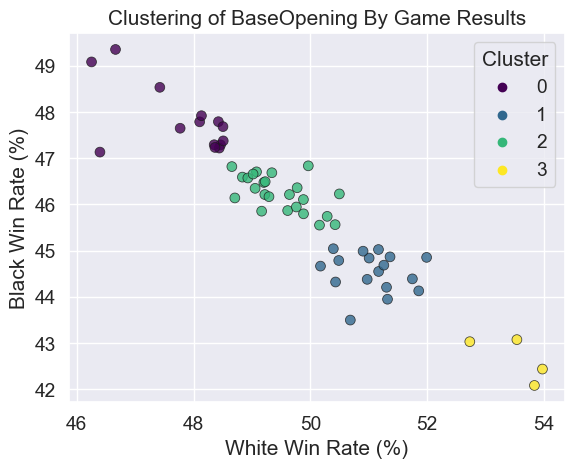

Silhouette Score: 0.47847574458966885


In [159]:
# Create a scatter plot with different colors for each cluster.
sns.set(font_scale=1.25)
scatter = sns.scatterplot(
    x="1-0",
    y="0-1",
    hue="Cluster",
    data=result_percentages_pivot_sorted_cluster,
    palette="viridis",
    s=50,
    edgecolor="k",
    alpha=0.8,
)
scatter.set(xlabel="White Win Rate (%)", ylabel="Black Win Rate (%)")
scatter.set_title("Clustering of BaseOpening By Game Results")
plt.show()

print(f"Silhouette Score: {silhouette_score(clustering_data_pd, kmeans.labels_)}")


### Regression Analysis of BaseOpening Popularity


#### BaseOpening Popularity vs. White Win Rate


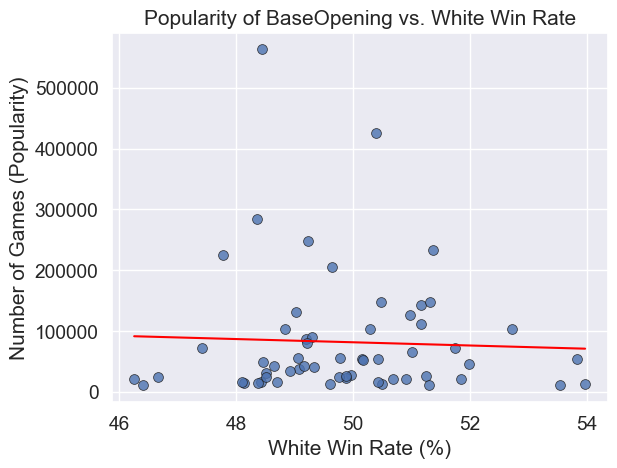

R2 Score: 0.0018371994924221147


In [151]:
# Extract the popularity (number of games) and win rate for White (1-0) for
# each BaseOpening.
regression_data = result_percentages_pivot_sorted[["NumberOfGames", "1-0"]]

# Create the linear regression model.
lr = LinearRegression()
X = regression_data[["1-0"]]
y = regression_data["NumberOfGames"]
lr.fit(X, y)

# Create a scatter plot with the data.
scatter = sns.scatterplot(
    x="1-0",
    y="NumberOfGames",
    data=regression_data,
    s=50,
    edgecolor="k",
    alpha=0.8,
)
sns.lineplot(
    x=regression_data["1-0"],
    y=lr.predict(X),
    color="red",
)
scatter.set(xlabel="White Win Rate (%)", ylabel="Number of Games (Popularity)")
scatter.set_title("Popularity of BaseOpening vs. White Win Rate")
plt.show()

print(f"R2 Score: {r2_score(y, lr.predict(X))}")


#### BaseOpening Popularity vs. Black Win Rate


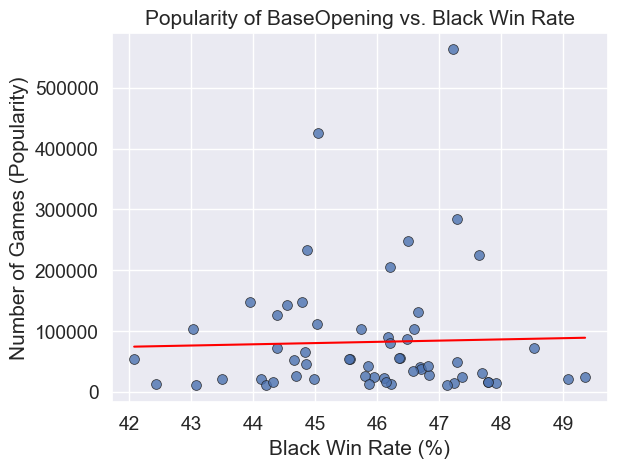

R2 Score: 0.0009381166683464226


In [152]:
# Extract the popularity (number of games) and win rate for Black (0-1) for
# each BaseOpening.
regression_data = result_percentages_pivot_sorted[["NumberOfGames", "0-1"]]

# Create the linear regression model.
lr = LinearRegression()
X = regression_data[["0-1"]]
y = regression_data["NumberOfGames"]
lr.fit(X, y)

# Create a scatter plot with the data.
scatter = sns.scatterplot(
    x="0-1",
    y="NumberOfGames",
    data=regression_data,
    s=50,
    edgecolor="k",
    alpha=0.8,
)
sns.lineplot(
    x=regression_data["0-1"],
    y=lr.predict(X),
    color="red",
)
scatter.set(xlabel="Black Win Rate (%)", ylabel="Number of Games (Popularity)")
scatter.set_title("Popularity of BaseOpening vs. Black Win Rate")
plt.show()

print(f"R2 Score: {r2_score(y, lr.predict(X))}")


#### BaseOpening Popularity vs. Draw Rate (%)


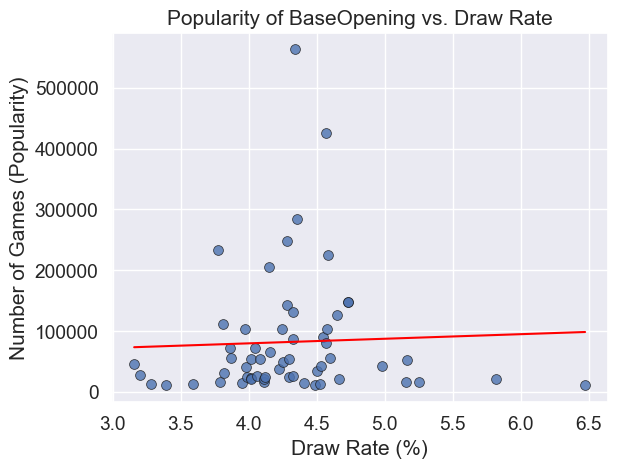

R2 Score: 0.0017195962263908404


In [153]:
# Extract the popularity (number of games) and draw rate (1/2-1/2) for
# each BaseOpening.
regression_data = result_percentages_pivot_sorted[["NumberOfGames", "1/2-1/2"]]

# Create the linear regression model.
lr = LinearRegression()
X = regression_data[["1/2-1/2"]]
y = regression_data["NumberOfGames"]
lr.fit(X, y)

# Create a scatter plot with the data.
scatter = sns.scatterplot(
    x="1/2-1/2",
    y="NumberOfGames",
    data=regression_data,
    s=50,
    edgecolor="k",
    alpha=0.8,
)
sns.lineplot(
    x=regression_data["1/2-1/2"],
    y=lr.predict(X),
    color="red",
)
scatter.set(xlabel="Draw Rate (%)", ylabel="Number of Games (Popularity)")
scatter.set_title("Popularity of BaseOpening vs. Draw Rate")
plt.show()

print(f"R2 Score: {r2_score(y, lr.predict(X))}")
